*Libraries*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

### Pre-proccess and cleaning

Functions for data cleaning

In [2]:
class DataProcessor:
    def __init__(self, df):
        self.df = df

    def clean_data(self):
        self.fix_na()
        self.create_new_columns()
        self.drop_cols()
        return self.df

    def fix_na(self):
        print(self.df.columns)
        # print columns with na
        print(self.df.columns[self.df.isna().any()].tolist(), "\n")

        # print na count for each column
        print(self.df.isna().sum(), "\n")
        temp_df = self.df

        # replace all na origin countries with CN because most origin countries are CN
        temp_df['origin_country'] = temp_df['origin_country'].fillna('CN')

        # replace urgency banner, rating_five_count, rating_four_count, rating_three_count,
        # rating_two_count, rating_one_count na with 0
        temp_df['has_urgency_banner'] = temp_df['has_urgency_banner'].fillna(0)
        temp_df['rating_five_count'] = temp_df['rating_five_count'].fillna(0)
        temp_df['rating_four_count'] = temp_df['rating_four_count'].fillna(0)
        temp_df['rating_three_count'] = temp_df['rating_three_count'].fillna(0)
        temp_df['rating_two_count'] = temp_df['rating_two_count'].fillna(0)
        temp_df['rating_one_count'] = temp_df['rating_one_count'].fillna(0)

        # find most frequent colors and replace na with the according to frequency
        color_counts = temp_df['product_color'].value_counts().head(10)
        colors = color_counts.index
        freqs = color_counts.values
        # Calculate the number of missing values in the column
        na_count = temp_df['product_color'].isna().sum()
        # Generate random values to fill NA
        fill_values = np.random.choice(colors, size=na_count, p=freqs / freqs.sum())
        # Fill NA values in the column with the generated values
        temp_df.loc[temp_df['product_color'].isna(), 'product_color'] = fill_values
        self.df = temp_df

    def create_new_columns(self):
        temp_df = self.df
        # new feature that check if item title was changed
        temp_df['changed_title'] = np.where(temp_df['title'] == temp_df['title_orig'], 1, 0)
        temp_df = temp_df.drop(columns=['title_orig'])

        # new feature that keep all the tags that appear more than 50 times as on hot encoded column
        tags = temp_df['tags'].str.split(',', expand=True).stack().value_counts()
        tags = tags[tags > 100]
        tags = tags.index
        for tag in tags:
            temp_df[tag + "_tag"] = temp_df['tags'].str.contains(tag).astype(int)

        # new feature that holds tag count
        temp_df['tag_count'] = temp_df['tags'].str.split(',').str.len()

        # drop tags
        temp_df = temp_df.drop(columns=['tags'])

        # new feature that shows difference between actual price and retail price
        temp_df['price_diff'] = temp_df['price'] - temp_df['retail_price']

        # new feature that one hot encodes the most common colors
        temp_df = self.fix_color_col(temp_df)
        one_hot = pd.get_dummies(temp_df['product_color']).astype(int)
        # temp_df = temp_df.drop(columns=['product_color'])
        temp_df = pd.concat([temp_df, one_hot], axis=1)

        # new feature that one hot encodes if shipping_option_name is Livraison standard or not
        temp_df['is_livraison_standard_shipping'] = np.where(temp_df['shipping_option_name'] == 'Livraison standard', 1,0)
        temp_df = temp_df.drop(columns=['shipping_option_name'])

        # new feature that one hot encodes if origin_country is CN or not
        temp_df['origin_country'].replace("CN", "CHN", inplace=True)
        temp_df['origin_country'].replace("US", "UAS", inplace=True)
        temp_df['origin_country'].replace("VE", "VEN", inplace=True)
        temp_df['origin_country'].replace("GB", "GBR", inplace=True)
        temp_df['origin_country'].replace("AT", "AUT", inplace=True)
        one_hot = pd.get_dummies(temp_df['origin_country']).astype(int)
        # temp_df = temp_df.drop(columns=['origin_country'])
        temp_df = pd.concat([temp_df, one_hot], axis=1)
        self.df = temp_df


    def fix_color_col(self, temp_df):
        temp_df['product_color'] = temp_df['product_color'].str.lower()
        temp_df['product_color'].replace("grey", "gray", inplace=True)
        top_colors = temp_df['product_color'].value_counts().index[:18].tolist()

        def match_colors(color_option):
            for color in top_colors:
                if color in color_option: return color
            return "other"

        temp_df['product_color'] = temp_df['product_color'].apply(match_colors)
        return temp_df

    def drop_cols(self):
        # First we will drop columns that are not useful for our analysis - merchant_profile_picture,
        # merchant_info_subtitle, merchant_id, merchant_name (it is the same for each merchant title)
        # crawl_month, theme, product_picture, product_url, currency_buyer - these are all also irelevant
        temp_df = self.df
        temp_df = temp_df.drop(
            columns=['merchant_profile_picture', 'merchant_info_subtitle', 'merchant_id', 'merchant_name',
                     'crawl_month', 'theme', 'product_picture', 'product_url', 'currency_buyer',
                     'product_variation_size_id', 'product_id', 'merchant_title', 'urgency_text'])
        self.df = temp_df


In [3]:
data = pd.read_csv('summer_products_data.csv')
data_processor = DataProcessor(data)

data_processor.clean_data()

Index(['title', 'title_orig', 'price', 'retail_price', 'currency_buyer',
       'units_sold', 'uses_ad_boosts', 'rating', 'rating_count',
       'rating_five_count', 'rating_four_count', 'rating_three_count',
       'rating_two_count', 'rating_one_count', 'badges_count',
       'badge_local_product', 'badge_product_quality', 'badge_fast_shipping',
       'tags', 'product_color', 'product_variation_size_id',
       'product_variation_inventory', 'shipping_option_name',
       'shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'has_urgency_banner', 'urgency_text',
       'origin_country', 'merchant_title', 'merchant_name',
       'merchant_info_subtitle', 'merchant_rating_count', 'merchant_rating',
       'merchant_id', 'merchant_has_profile_picture',
       'merchant_profile_picture', 'product_url', 'product_picture',
       'product_id', 'theme', 'crawl_month'],
      dtype='object')
['rating_five_count', 'rating_four_count', 'rating_three

,title,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,...,red,white,yellow,is_livraison_standard_shipping,AUT,CHN,GBR,SG,UAS,VEN
0,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,100,0,3.76,54,26.0,8.0,10.0,...,0,1,0,1,0,1,0,0,0,0
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,8.00,22,20000,1,3.45,6135,2269.0,1027.0,1118.0,...,0,0,0,1,0,1,0,0,0,0
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,8.00,43,100,0,3.57,14,5.0,4.0,2.0,...,0,0,0,1,0,1,0,0,0,0
3,Hot Summer Cool T-shirt pour les femmes Mode T...,8.00,8,5000,1,4.03,579,295.0,119.0,87.0,...,0,0,0,1,0,1,0,0,0,0
4,Femmes Shorts d'été à lacets taille élastique ...,2.72,3,100,1,3.10,20,6.0,4.0,2.0,...,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,Nouvelle Mode Femmes Bohême Pissenlit Imprimer...,6.00,9,10000,1,4.08,1367,722.0,293.0,185.0,...,0,0,0,1,0,1,0,0,0,0
1569,10 couleurs femmes shorts d'été lacent ceintur...,2.00,56,100,1,3.07,28,11.0,3.0,1.0,...,0,0,0,1,0,1,0,0,0,0
1570,Nouveautés Hommes Siwmwear Beach-Shorts Hommes...,5.00,19,100,0,3.71,59,24.0,15.0,8.0,...,0,1,0,1,0,1,0,0,0,0
1571,Mode femmes d'été sans manches robes col en V ...,13.00,11,100,0,2.50,2,0.0,1.0,0.0,...,0,1,0,1,0,1,0,0,0,0


Data exploration

In [4]:
class DataExplorer:
    def __init__(self, df):
        self.df = df

    def basic_stats(self):
        # Print basic statistics for each column
        pd.set_option('display.max_columns', None)
        numerical_columns = self.df.select_dtypes(include=[np.number])
        stats = numerical_columns.agg(['mean', 'median', 'std'])
        return stats

    def visualize_data(self):
        sns.set_palette('bright')
        font_title = {'fontweight': 'bold', 'fontsize': 14}
        font_label = {'fontweight': 'bold', 'fontsize': 12}
        
        # Drop non-numerical columns
        numerical_columns = self.df.select_dtypes(include=[np.number])

        # Function to check if a column contains binary values (0 or 1)
        def is_binary(column):
            return all(value in [0, 1] for value in column)
        
        # Get the column names with binary values
        binary_columns = [column for column in numerical_columns.columns if is_binary(numerical_columns[column])]

        # Drop these columns from the DataFrame
        numerical_columns = numerical_columns.drop(columns = binary_columns)
        num_plots = len(numerical_columns.columns)
        num_rows = int(np.ceil(num_plots / 3))
        
        # Create a grid for plots
        fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))

        for i, column in enumerate(numerical_columns.columns):
            ax = axes[i // 3, i % 3]
            sns.histplot(self.df[column], ax=ax, bins=30, kde=True)
            ax.set_title(f"Histogram of {column}")
            ax.set_xlabel(column)
            ax.set_ylabel("Frequency")
        
        # Remove any unused subplots
        for j in range(i+1, num_rows * 3):
            fig.delaxes(axes.flatten()[j])

        plt.tight_layout()
        plt.show()

        # origin_country graph
        column = "origin_country"
        plt.figure()
        sns.countplot(data=self.df, x=column)
        title = f"Bar Graph of {column}"
        plt.title(title, **font_title)
        plt.xlabel(column, **font_label)
        plt.ylabel("Count", **font_label)
        plt.show()

        # Stacked bar plot for breakdowns of rating columns
        ratings = ['rating_five_count', 'rating_four_count', 'rating_three_count', 'rating_two_count',
                   'rating_one_count']
        rating_sums = self.df[ratings].sum()
        star_labels = ['★' * i for i in range(5, 0, -1)]
        fig, ax = plt.subplots(figsize=(10, 6))
        rating_sums.plot(kind='bar', ax=ax)
        ax.set_xticklabels(star_labels, rotation=0)
        title = 'Breakdown of Ratings'
        plt.title(title)
        plt.ylabel('Count')
        plt.xlabel('Rating')
        plt.tight_layout()
        plt.show()
        plt.close()

        # color graph
        color_counts = self.df['product_color'].value_counts()
        color_mapping = {
            'other': 'grey'
        }
        bar_colors = {"multicolor": 'red'}
        hatch_patterns = {"multicolor": '///'}
        hatch_colors = {"multicolor": 'blue'}
        colors = color_counts.index.tolist()
        counts = color_counts.values.tolist()
        fig, ax = plt.subplots()
        for i, color in enumerate(colors):
            if color in hatch_patterns:
                ax.bar(i, counts[i], color=bar_colors[color], edgecolor=hatch_colors[color],
                       hatch=hatch_patterns[color])
                continue
            ax.bar(i, counts[i], edgecolor='black', color=color_mapping.get(color, color))
        title = f"Bar Graph of product_color"
        plt.title(title, **font_title)
        ax.set_xticks(range(len(colors)))
        plt.xticks(rotation=30, size=8)
        ax.set_xticklabels(colors)
        plt.show()
        
        # Create a figure and a grid of subplots with 2 rows and 2 columns
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

        # Plot 1: Price vs Retail Price
        sns.scatterplot(data=self.df, x='price', y='retail_price', ax=axes[0, 0])
        axes[0, 0].set_title('Price vs Retail Price')

        # Plot 2: Rating vs Units Sold
        sns.scatterplot(data=self.df, x='rating', y='units_sold', ax=axes[0, 1])
        axes[0, 1].set_title('Rating vs Units Sold')

        # Plot 3: Merchant Rating vs Rating
        sns.scatterplot(data=self.df, x='merchant_rating', y='rating', ax=axes[1, 0])
        axes[1, 0].set_title('Merchant Rating vs Rating')

        # Plot 4: Price vs Units Sold
        sns.scatterplot(data=self.df, x='price', y='units_sold', ax=axes[1, 1])
        axes[1, 1].set_title('Price vs Units Sold')

        # Adjust the layout to avoid overlapping titles
        plt.tight_layout()

        # Show the plots
        plt.show()


        # Correlation heatmap for rating against other numeric columns
        correlation_matrix = self.df[
            ['rating', 'price', 'retail_price', 'units_sold', 'merchant_rating_count', 'merchant_rating']].corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        title = 'Correlation Heatmap'
        plt.title(title)
        # make ticks bold
        plt.yticks(rotation=20, size=7, weight='bold')
        plt.xticks(rotation=10, size=8, weight='bold')
        plt.show()
        plt.close()

        

        # map graph
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        df_country_count = self.df['origin_country'].value_counts().reset_index()
        df_country_count.columns = ['country', 'count']

        merged = world.set_index('iso_a3').join(df_country_count.set_index('country'))
        merged['count'] = merged['count'].fillna(0)
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        merged.plot(column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
        title = 'Products Origin by Country'
        ax.set_title(title)
        plt.show()
        plt.close()


In [5]:
data_exploration = DataExplorer(data_processor.df)
data_exploration.basic_stats()

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_variation_inventory,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,merchant_rating_count,merchant_rating,merchant_has_profile_picture,changed_title,Summer_tag,Women's Fashion_tag,Fashion_tag,Women_tag,Casual_tag,Plus Size_tag,sleeveless_tag,Dress_tag,Shorts_tag,Tops_tag,sexy_tag,Beach_tag,Sleeve_tag,short sleeves_tag,Print_tag,Shirt_tag,Tank_tag,Necks_tag,V-neck_tag,T Shirts_tag,printed_tag,tank top_tag,Cotton_tag,Ladies_tag,summer dress_tag,Loose_tag,blouse_tag,pants_tag,Vest_tag,beach dress_tag,women dress_tag,Floral_tag,Lace_tag,Mini dress_tag,Mini_tag,slim_tag,Sleeveless dress_tag,Women Fashion_tag,Round neck_tag,casual dress_tag,Waist_tag,party_tag,long dress_tag,Party Dress_tag,Sport_tag,Floral print_tag,Slim Fit_tag,Spaghetti_tag,backless_tag,tag_count,price_diff,beige,black,blue,gray,green,khaki,multicolor,orange,other,pink,purple,red,white,yellow,is_livraison_standard_shipping,AUT,CHN,GBR,SG,UAS,VEN
mean,8.325372,23.288620,4339.005086,0.432931,3.820896,889.659250,429.611570,174.461538,130.700572,61.888748,92.996821,0.105531,0.018436,0.074380,0.012715,33.081373,2.345200,0.002543,40.456453,49.821360,0.300699,26495.832804,4.032345,0.143675,0.097902,0.846154,0.836618,0.950413,0.876669,0.593770,0.406866,0.376351,0.354736,0.344565,0.337572,0.245391,0.214876,0.314685,0.188175,0.203433,0.265099,0.176097,0.161475,0.157025,0.153846,0.165925,0.155118,0.161475,0.136682,0.174189,0.134774,0.146853,0.144946,0.129053,0.117610,0.120788,0.122060,0.115702,0.108074,0.131596,0.124603,0.095995,0.090273,0.088366,0.099809,0.084552,0.085188,0.079466,0.090273,0.080102,0.068659,0.068023,0.083280,0.073109,17.390337,-14.963249,0.00890,0.212969,0.104259,0.054673,0.091545,0.008264,0.012715,0.017800,0.037508,0.073109,0.034965,0.091545,0.179275,0.072473,0.958678,0.000636,0.974571,0.000636,0.001271,0.019708,0.003179
median,8.000000,10.000000,1000.000000,0.000000,3.850000,150.000000,72.000000,29.000000,22.000000,10.000000,18.000000,0.000000,0.000000,0.000000,0.000000,50.000000,2.000000,0.000000,40.000000,50.000000,0.000000,7936.000000,4.040650,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,-0.200000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
std,3.932030,30.357863,9356.539302,0.495639,0.515374,1983.928834,968.882684,395.876511,308.015310,149.539900,211.592341,0.340709,0.134565,0.262472,0.112075,21.353137,1.024371,0.050379,20.301203,2.562799,0.458708,78474.455607,0.204768,0.350871,0.297277,0.360916,0.369831,0.217159,0.328922,0.491285,0.491406,0.484624,0.478585,0.475377,0.473032,0.430456,0.410867,0.464538,0.390977,0.402680,0.441526,0.381023,0.368085,0.363940,0.360916,0.372132,0.362132,0.368085,0.343620,0.379393,0.341591,0.354072,0.352158,0.335365,0.322248,0.325985,0.327459,0.319970,0.310572,0.338158,0.330373,0.294678,0.286664,0.283917,0.299841,0.278302,0.279249,0.270551,0.286664,0.271537,0.252953,0.251865,0.276393,0.260398,4.066115,29.399090,0.09395,0.409536,0.305694,0.227412,0.288474,0.090561,0.112075,0.132267,0.190063,0.260398,0.183750,0.288474,0.383705,0.259352,0.199098,0.025214,0.157475,0.025214,0.035646,0.139038,0.056308


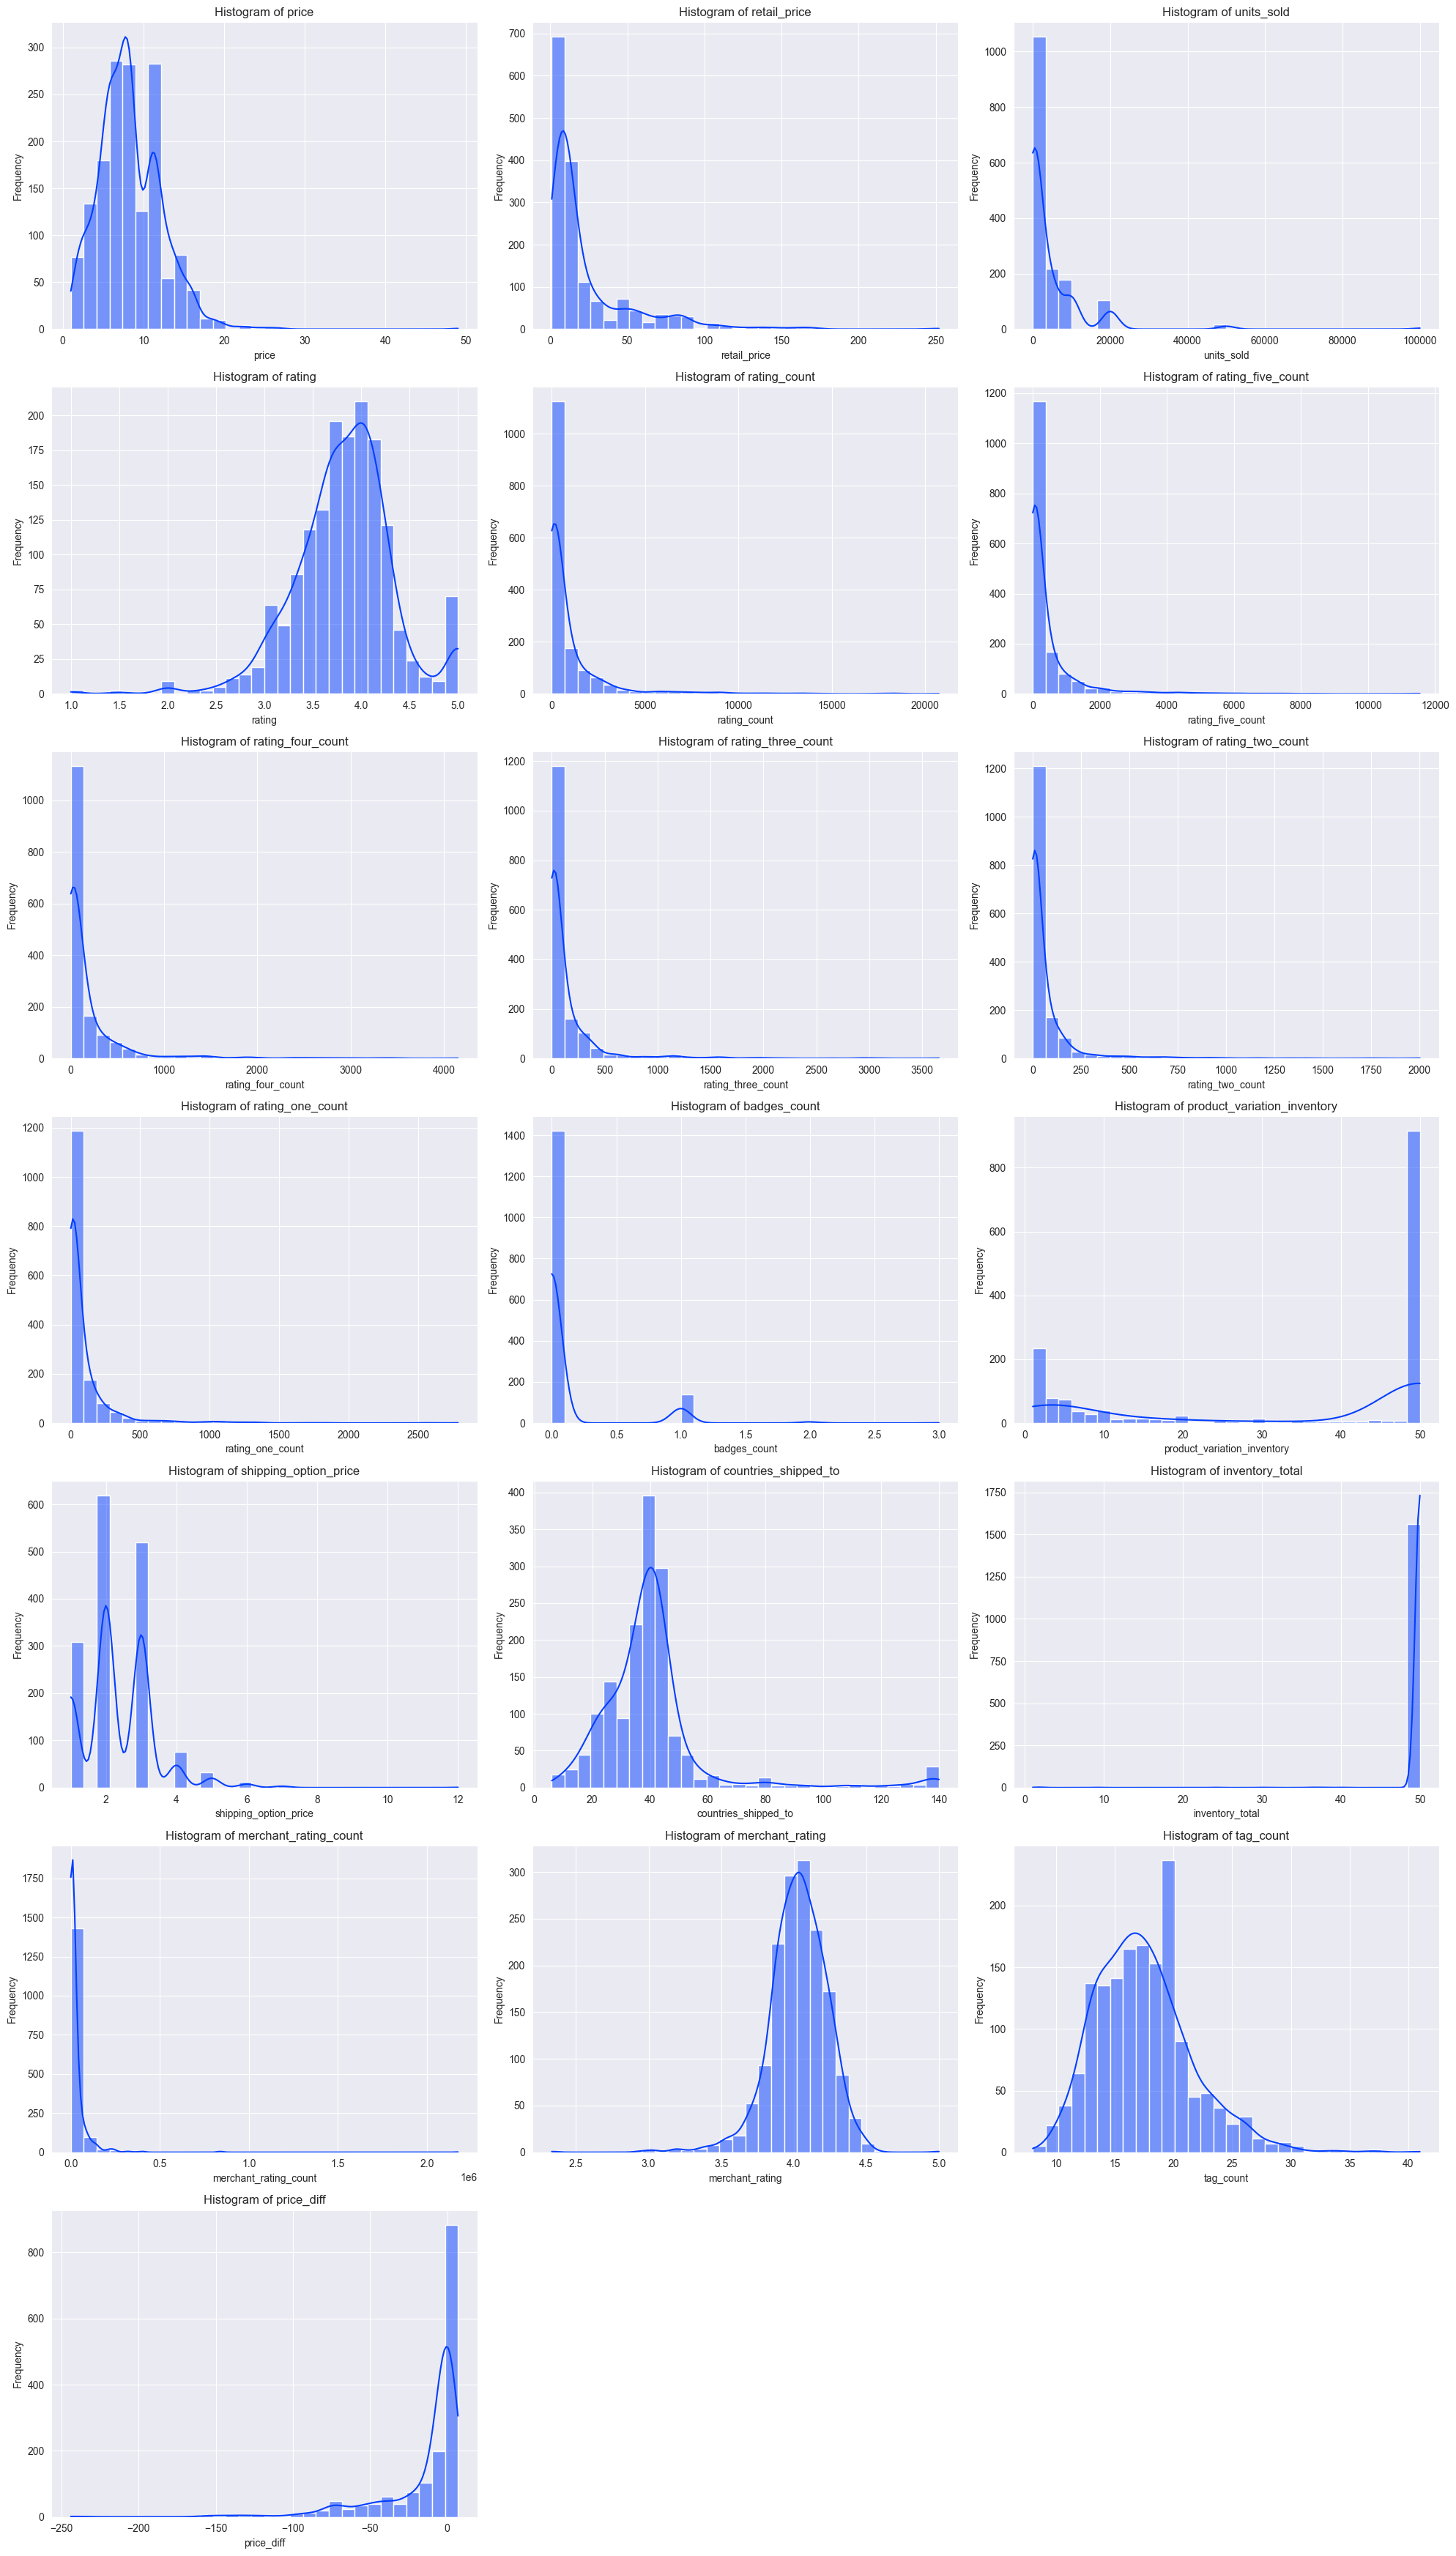

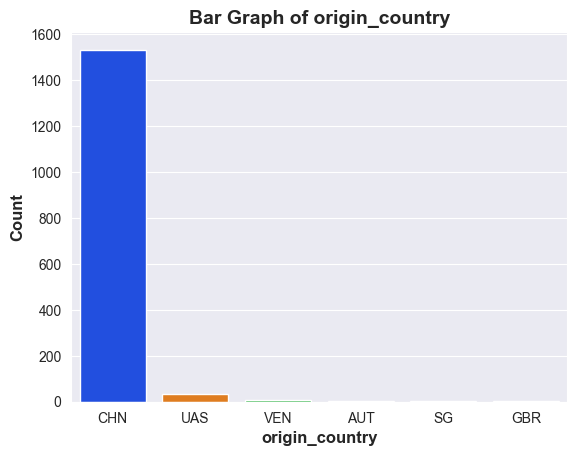

/var/folders/fc/d4f_22g103q8yvr7x7hk7t5h0000gp/T/ipykernel_54035/1814602409.py:71: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  plt.tight_layout()
/Users/mattisevitt/University/Data Science/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


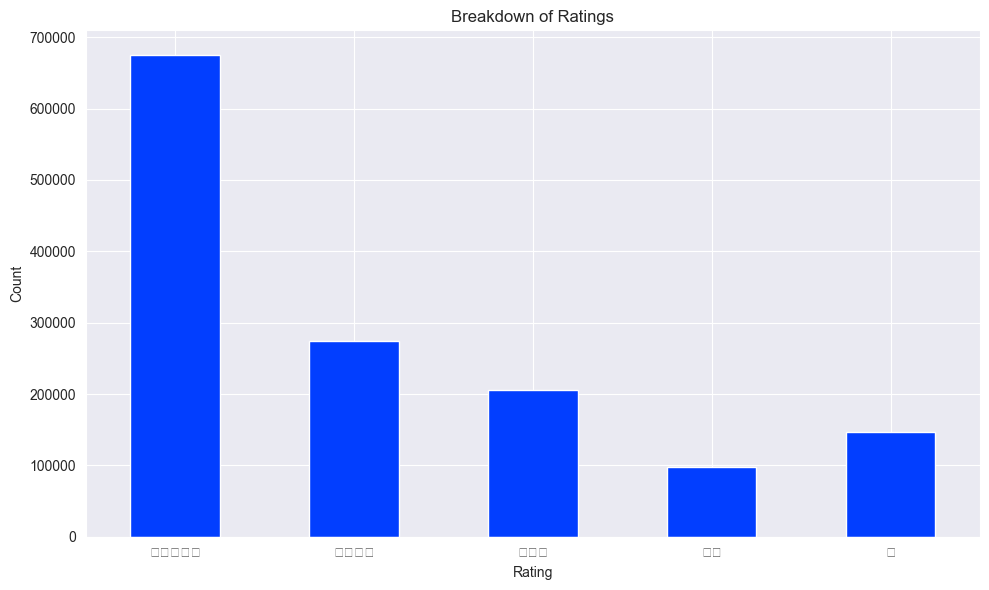

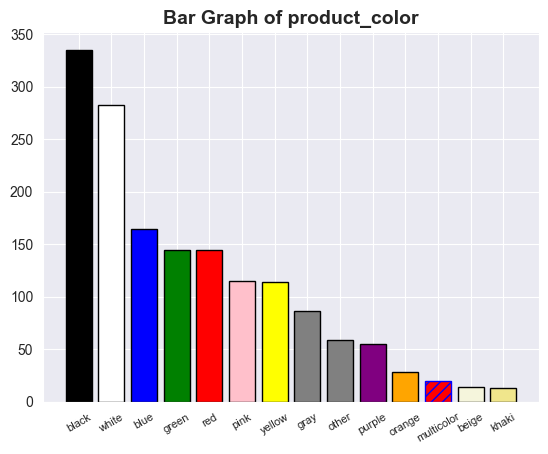

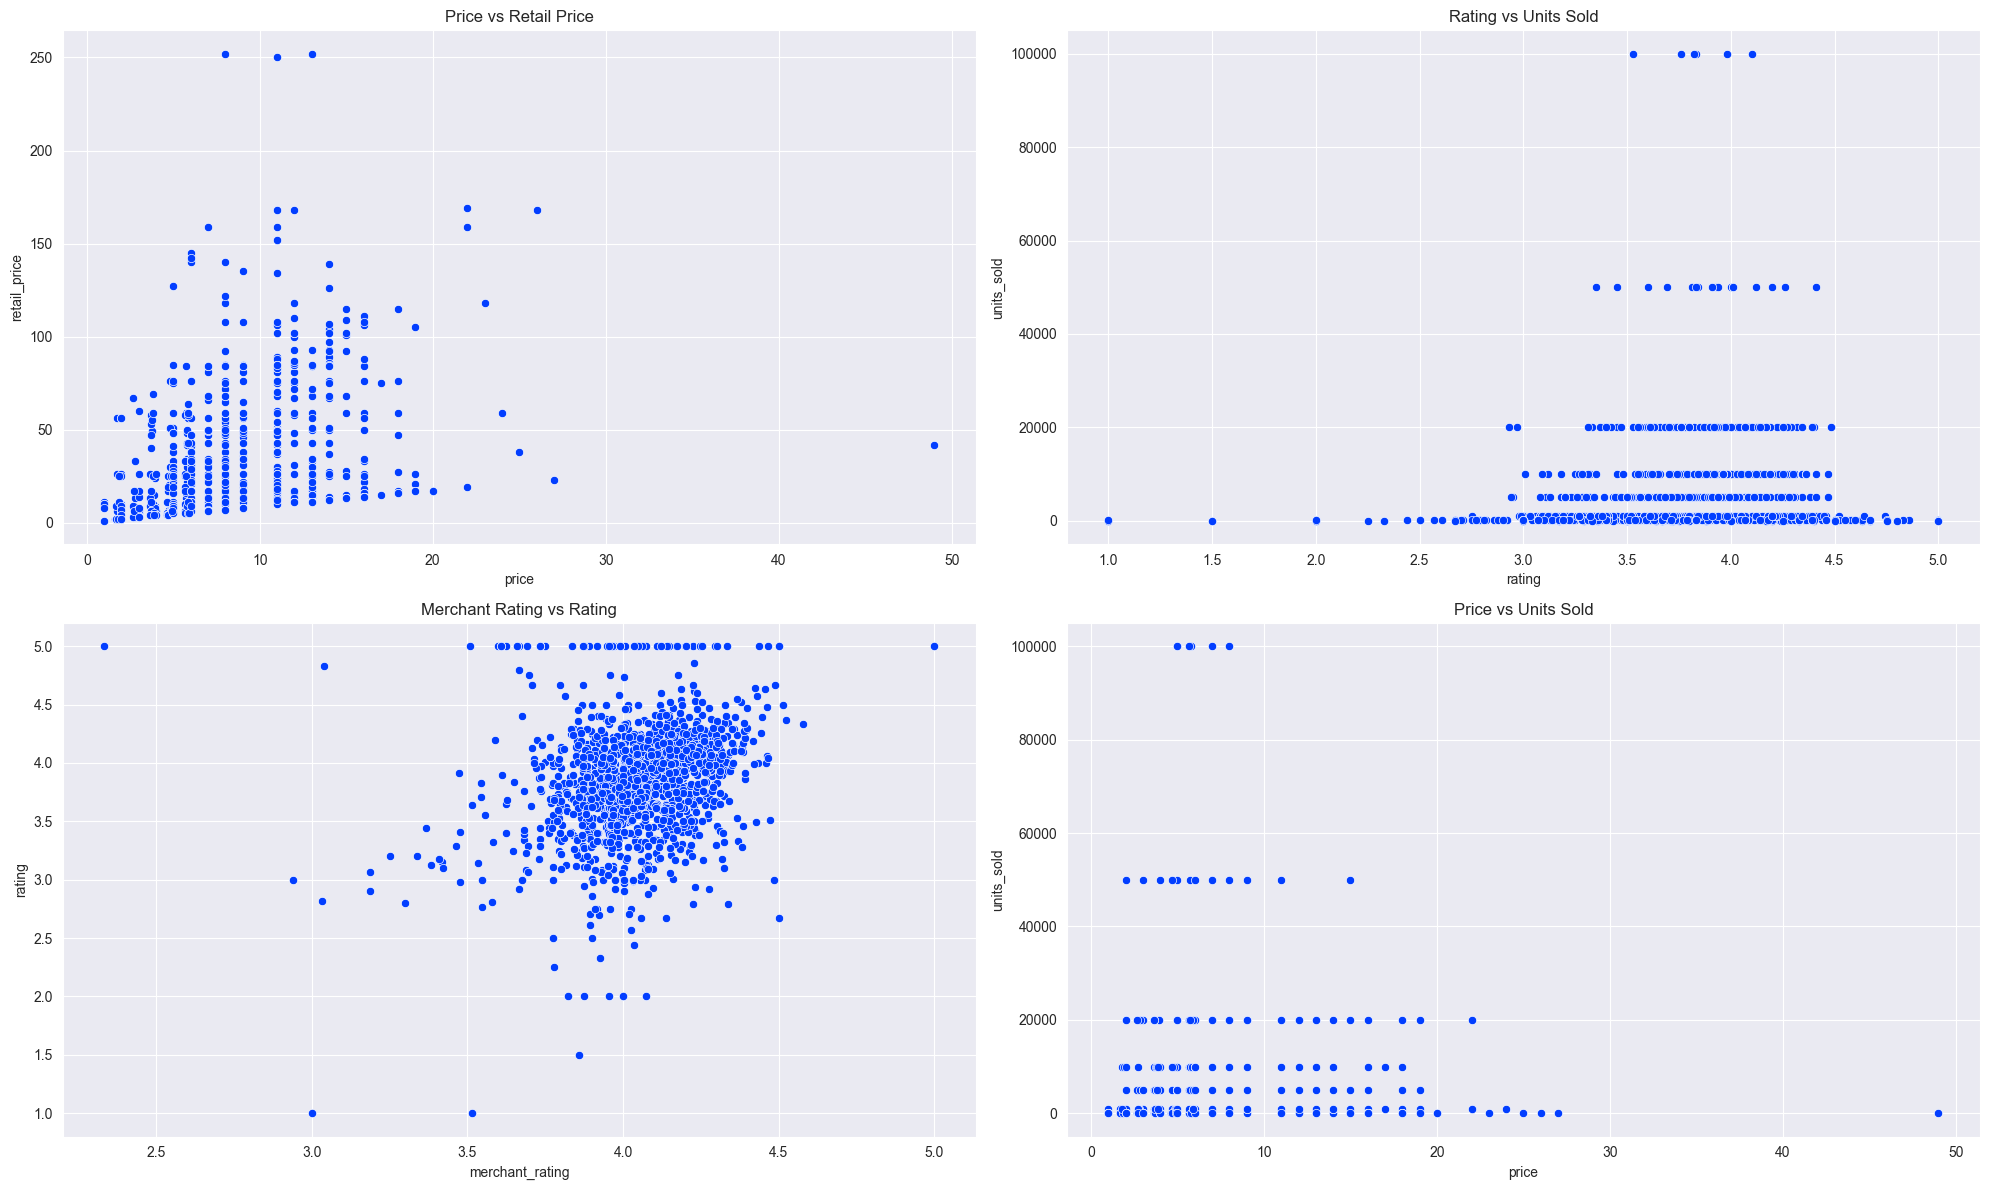

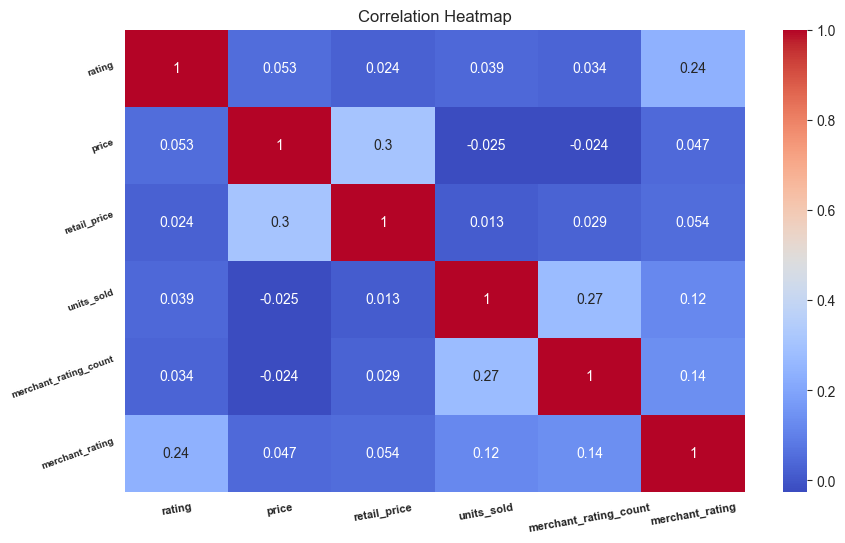

/var/folders/fc/d4f_22g103q8yvr7x7hk7t5h0000gp/T/ipykernel_54035/1814602409.py:141: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


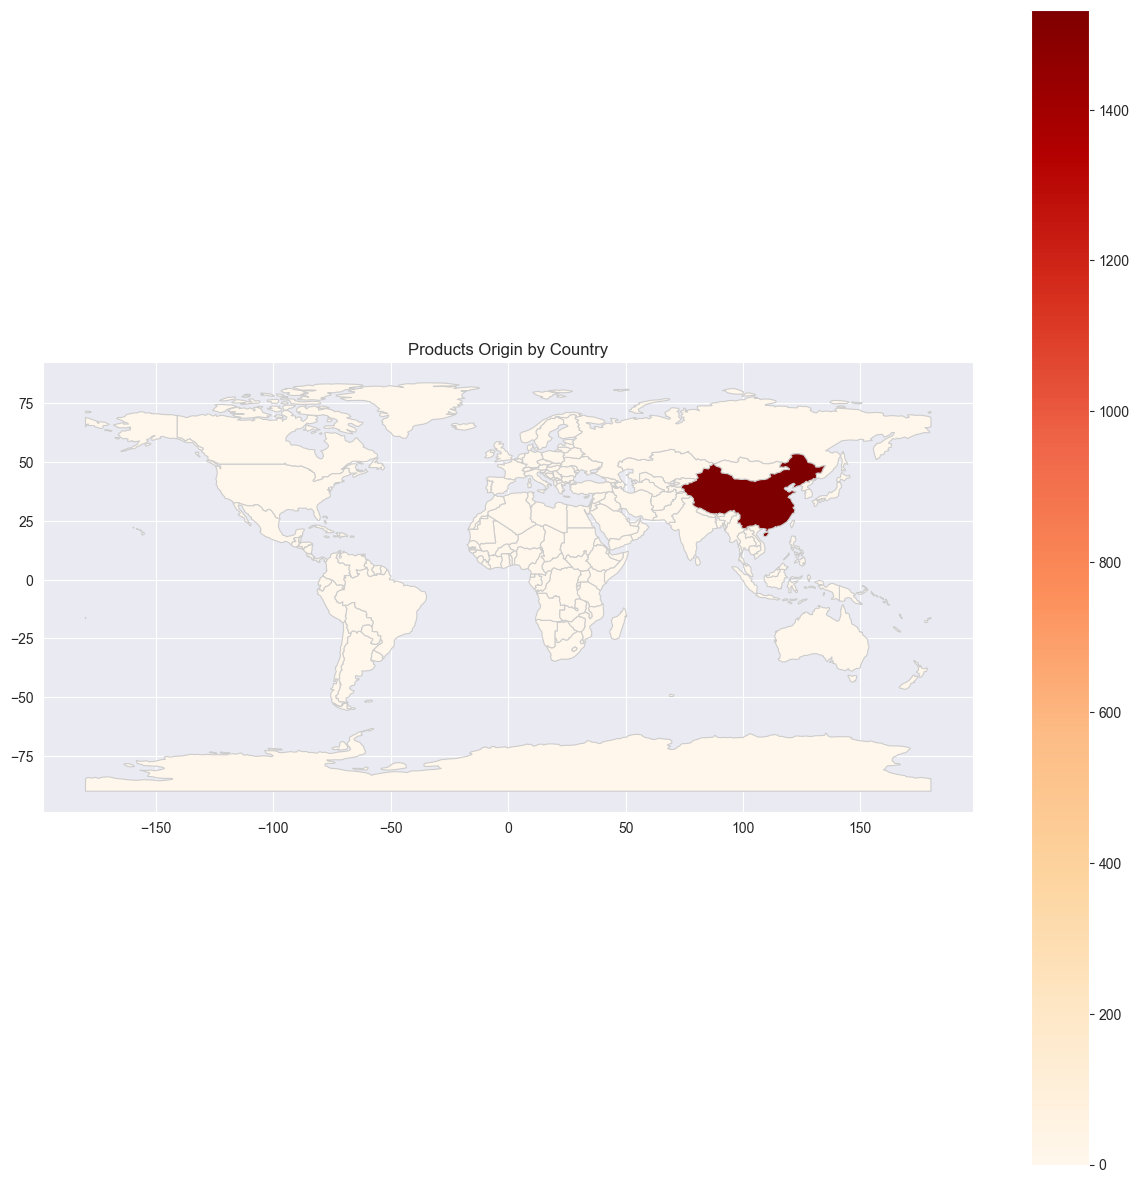

In [6]:
data_exploration.visualize_data()

Model

Let's start with a simple regression model using some numeric and binary features:

First, we want to predict units sold

Features:
price
retail_price
uses_ad_boosts
rating
rating_count

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Selecting features and target variable
data = data_exploration.df
features = ['price', 'retail_price', 'uses_ad_boosts', 'rating', 'rating_count']
X = data[features]
y = data['units_sold']

# Splitting data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print(f"Coefficients: {regressor.coef_}, Intercept: {regressor.intercept_}, R^2 score: {regressor.score(X_train, y_train)}")

# Predicting on the test set
y_pred = regressor.predict(X_test)

# Calculating the Mean Squared Error (MSE) for performance evaluation
rmse = mean_squared_error(y_test, y_pred)**0.5
rmse

Coefficients: [-10.66791535 -10.73172709 519.99960556 -16.94325528   4.09765711], Intercept: 813.7922594992356, R^2 score: 0.7986352888828936


4029.513157663454

As we can see we get a pretty high R^2, yet high mse. Let's apply some more feature engineering and some more data cleaning

In [8]:
# Feature Engineering

# Extracting title length in terms of words and characters
data['title_word_count'] = data['title'].apply(lambda x: len(str(x).split()))
data['title_char_count'] = data['title'].apply(len)

# Creating a derived feature for the difference between retail_price and price
data['price_difference'] = data['retail_price'] - data['price']

# Updating the features list
features_extended = features + ['title_word_count', 'title_char_count', 'price_difference']

# Displaying the first few rows of the dataset with the new features
data[features_extended].head()

# Function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtering out the outliers
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

# Removing outliers from the identified columns
columns_with_outliers = ['rating_count', 'retail_price', 'price_difference']
for col in columns_with_outliers:
    data = remove_outliers(data, col)

Repeat the model

In [ ]:
X = data[features]
y = data['units_sold']

# Splitting data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print(f"Coefficients: {regressor.coef_}, Intercept: {regressor.intercept_}, R^2 score: {regressor.score(X_train, y_train)}")

# Predicting on the test set
y_pred = regressor.predict(X_test)

# Calculating the Mean Squared Error (MSE) for performance evaluation
rmse = mean_squared_error(y_test, y_pred)**0.5
rmse

Now that's a far better rmse, with not much loss of R^2.

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Splitting the cleaned data into training and testing sets
X = data[features_extended]
y = data['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the models
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Training and evaluating the models
rmse_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_results[name] = np.sqrt(mean_squared_error(y_test, y_pred))

rmse_results

{'Decision Tree': 2191.0821645121373,
 'Random Forest': 1913.0085248324665,
 'Gradient Boosting': 1966.6918614592364}

Now we woulld like to analyze the data using classification methods, the research question that interests us is if we are able to predict the rating of a product (between 1 and 5 stars) based on it's initial features.
We will test different classification models and compare their results.

In [46]:
data = data_exploration.df
features_to_remove = ['title', 'rating', 'rating_count', 'rating_five_count', 'rating_four_count', 'rating_three_count', 'rating_two_count', 'rating_one_count', 'product_color', 'origin_country','units_sold']
X = data.drop(features_to_remove, axis=1)
y = data['rating'].round().clip(1, 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)


First we will try out Decision Tree Classifier

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
mse = mean_squared_error(y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 71.75%

Classification Report:
              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67         1
         2.0       0.50      0.50      0.50         4
         3.0       0.47      0.55      0.50        64
         4.0       0.85      0.79      0.82       229
         5.0       0.36      0.47      0.41        17

    accuracy                           0.72       315
   macro avg       0.54      0.66      0.58       315
weighted avg       0.74      0.72      0.73       315



As we can see the accuracy is pretty good (73.33%) but we think we can do better. Remembering that Random Forest is a lot of decision trees put together (sort of), we decided to try out Random Forest.

In [73]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Now let's evaluate the model's accuracy score

In [74]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred), "\n\n")
print(classification_report(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)

Accuracy Score:  0.8317460317460318 


              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         2.0       1.00      0.50      0.67         4
         3.0       0.88      0.45      0.60        64
         4.0       0.82      0.99      0.90       229
         5.0       0.80      0.24      0.36        17

    accuracy                           0.83       315
   macro avg       0.90      0.64      0.71       315
weighted avg       0.84      0.83      0.81       315



As we can see for one and two star ratings the model is perfect, although this should be taken for granted as there are considerably less samples of these ratings in the dataset. for the other rating (3-5) the model was not perfect but still really good with a weighted average accuracy of 84%.

Explanation of columns:

Precision: This is the ratio of correctly predicted positive observations to the total predicted positives for each class.
Precision =True Positives / (True Positives + False Positives)

Recall (Sensitivity): This is the ratio of correctly predicted positive observations to the all actual positives for each class.
Recall = (True Positives True Positives + False Negatives)

F1-Score: This is the weighted average of Precision and Recall. It tries to find the balance between precision and recall.
F1 = 2 × (Precision×Recall) / (Precision + Recall)
​


Support: The number of actual occurrences of the class in the test set.



Now lets try and Improve this model by tuning the hyperparameters, in this case the hyperparameters are the number of estimators, max depth, min samples split and min samples leaf. We will use grid search to find the best hyperparameters for this model.

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 20, 50, 100, 125, 150],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("grid search best paramaters: ", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred), "\n\n")


/Users/mattisevitt/University/Data Science/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


grid search best paramaters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy Score:  0.8412698412698413 




As we can see the new tuned Random Forest Classifier show slightly better results (0.84 > 0.83) but not significantly.
Furthermore, the best parameters chosen are: 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100

In [67]:
importances = rf.feature_importances_
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]

for i, (name, importance) in enumerate(zip(feature_names[sorted_indices], importances[sorted_indices])):
    print(f"{i + 1}. Feature: {name}, Importance: {importance:.4f}")

1. Feature: merchant_rating_count, Importance: 0.0801
2. Feature: merchant_rating, Importance: 0.0776
3. Feature: countries_shipped_to, Importance: 0.0523
4. Feature: title_char_count, Importance: 0.0505
5. Feature: price, Importance: 0.0444
6. Feature: retail_price, Importance: 0.0421
7. Feature: title_word_count, Importance: 0.0404
8. Feature: price_difference, Importance: 0.0389
9. Feature: price_diff, Importance: 0.0372
10. Feature: tag_count, Importance: 0.0358
11. Feature: product_variation_inventory, Importance: 0.0254
12. Feature: shipping_option_price, Importance: 0.0208
13. Feature: Loose_tag, Importance: 0.0133
14. Feature: uses_ad_boosts, Importance: 0.0103
15. Feature: Casual_tag, Importance: 0.0098
16. Feature: Plus Size_tag, Importance: 0.0097
17. Feature: V-neck_tag, Importance: 0.0096
18. Feature: Print_tag, Importance: 0.0095
19. Feature: Floral_tag, Importance: 0.0090
20. Feature: Tops_tag, Importance: 0.0089
21. Feature: Necks_tag, Importance: 0.0089
22. Feature: Sh

It's interesting to see which features were more important to the model - that is a merchant's rating and rating count has the largest effect, but on the other hand the product's country has very little effect.
Now we will check out SVM and see if maybe we can get better results.

In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))